<a href="https://colab.research.google.com/github/paulgureghian/Google_Colab_Notebooks/blob/master/Save_and_load_PyTorch_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Created by Paul A. Gureghian on 11/28/18.**

**This notebook contains a blueprint for,**

**saving and loading PyTorch models.**

In [0]:
### Install CUDA driver
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
### Import packages
import torch
import fc_model
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import  datasets, transforms

In [0]:
### Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [0]:
### Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [0]:
### ### Download and load the testing data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

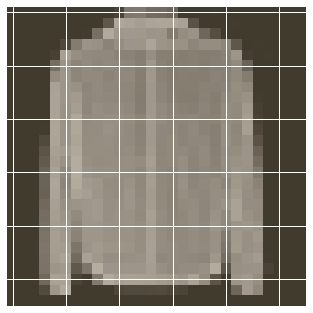

In [101]:
### View one of the images 
image, label = next(iter(trainloader))
imshow(image[0,:]);

In [0]:
### Create a network with hyperparams and metrics
model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [103]:
### Train the network 
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.695..  Test Loss: 0.995..  Test Accuracy: 0.680
Epoch: 1/2..  Training Loss: 1.078..  Test Loss: 0.768..  Test Accuracy: 0.712
Epoch: 1/2..  Training Loss: 0.872..  Test Loss: 0.681..  Test Accuracy: 0.745
Epoch: 1/2..  Training Loss: 0.806..  Test Loss: 0.666..  Test Accuracy: 0.743
Epoch: 1/2..  Training Loss: 0.756..  Test Loss: 0.615..  Test Accuracy: 0.762
Epoch: 1/2..  Training Loss: 0.725..  Test Loss: 0.594..  Test Accuracy: 0.770
Epoch: 1/2..  Training Loss: 0.691..  Test Loss: 0.593..  Test Accuracy: 0.780
Epoch: 1/2..  Training Loss: 0.666..  Test Loss: 0.553..  Test Accuracy: 0.793
Epoch: 1/2..  Training Loss: 0.673..  Test Loss: 0.566..  Test Accuracy: 0.792
Epoch: 1/2..  Training Loss: 0.661..  Test Loss: 0.560..  Test Accuracy: 0.792
Epoch: 1/2..  Training Loss: 0.645..  Test Loss: 0.576..  Test Accuracy: 0.783
Epoch: 1/2..  Training Loss: 0.630..  Test Loss: 0.511..  Test Accuracy: 0.814
Epoch: 1/2..  Training Loss: 0.637..  Test Loss: 0.5

In [104]:
### Print the model.state dictionary keys
print("Model :\n", model, '\n')
print("The state dict keys:\n ", model.state_dict().keys())

Model :
 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
) 

The state dict keys:
  odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [0]:
### Save the model to a file 
torch.save(model.state_dict(), 'checkpoint.pth')

In [106]:
### Load the model from a file 
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [0]:
### Load the 'state_dict' into the network
model.load_state_dict(state_dict)

In [108]:
### Model architecture must match the checkpoint architecture 
model = fc_model.Network(784, 10, [400, 200, 100])
model.load_state_dict(state_dict)

RuntimeError: ignored

In [0]:
### Rebuild the model
checkpoint = {'input_size': 784, 'output_size':10, 'hidden_layers': [each.out_features for each in model.hidden_layers], 'state_dict':model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

In [0]:
### Define a function to 'load_checkpoint'
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],checkpoint['output_size'],checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
  
    return model

In [0]:
### Load matched checkpoint architecture 
model = load_checkpoint('checkpoint.pth')